In [46]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
import torch
from pymatgen.core import Structure
from IPython.display import display

# Minimal imports from your modules (adjust paths as needed):
from bin.evaluate import load_model_from_checkpoint
from bin.train import TrainConfig
from decifer.tokenizer import Tokenizer
from decifer.utility import (
    pxrd_from_cif,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    space_group_to_crystal_system,
    space_group_symbol_to_number
)
import crystal_toolkit

from ase.visualize.plot import plot_atoms
from ase.data import colors, atomic_numbers

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.groups import SpaceGroup


class DeciferPipeline:
    def __init__(self, model_path, zip_path, device="cuda", temperature=1.0, max_new_tokens=3000):
        # Set up periodic table layout
        self.periodic_table_layout = [
            # Period 1
            ["H", None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, "He"],
            # Period 2
            ["Li", "Be", None, None, None, None, None, None, None, None, None, None, "B", "C", "N", "O", "F", "Ne"],
            # Period 3
            ["Na", "Mg", None, None, None, None, None, None, None, None, None, None, "Al", "Si", "P", "S", "Cl", "Ar"],
            # Period 4
            ["K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr"],
            # Period 5
            ["Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe"],
            # Period 6 Main Block
            ["Cs", "Ba", "La", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", None],
            # Period 7 Main Block
            ["Fr", "Ra", "Ac", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og", None],
            # Break
            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
            # Lanthanides (Period 6)
            [None, None, None, "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", None],
            # Actinides (Period 7)
            [None, None, None, "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", None]
        ]
        self.global_inactive_elements_list = []
        for row in self.periodic_table_layout:
            for el in row:
                if el is not None:
                    self.global_inactive_elements_list.append(el)
        
        # Initialize tokenizer and token-related variables
        self.TOKENIZER = Tokenizer()
        self.VOCAB_SIZE = self.TOKENIZER.vocab_size
        self.START_ID = self.TOKENIZER.token_to_id["data_"]
        self.PADDING_ID = self.TOKENIZER.padding_id
        self.NEWLINE_ID = self.TOKENIZER.token_to_id["\n"]
        self.SPACEGROUP_ID = self.TOKENIZER.token_to_id["_symmetry_space_group_name_H-M"]
        self.DECODE = self.TOKENIZER.decode
        self.ENCODE = self.TOKENIZER.encode
        self.TOKENIZE = self.TOKENIZER.tokenize_cif

        # Model and default parameters
        self.device = device
        self.model = self.load_custom_model(model_path)
        self.temperature = temperature
        self.max_new_tokens = max_new_tokens

        # Setup data
        self.df_exp = self.read_experimental_data(zip_path)
        self.df_processed = None
        self.results = None
        self.exp_i = None
        self.exp_q = None
        self.raw_i = None
        self.raw_q = None

    def prepare_target_data(self, target_file, background_file=None, q_min_crop=0.0, q_max_crop=10.0, wavelength='CuKa', n_points=1000):
        # set preparation config
        self.prep_config = {
            "target_file": target_file,
            "background_file": background_file,
            "q_min_crop": q_min_crop,
            "q_max_crop": q_max_crop,
            "wavelength": wavelength,
            "n_points": n_points,
        }
        self.df_processed = self.preprocess_generic(**self.prep_config)
        self.exp_q = self.df_processed['Q'].values
        self.exp_i = self.df_processed['intensity_crop_norm'].values
        self.raw_q = self.df_processed['Q'].values
        self.raw_i = self.df_processed['intensity_norm']

    def read_experimental_data(self, zip_path):
        """
        Reads and combines all .xy or .xye files in the zip,
        maps them to their compositions, and returns a single DataFrame.
        """
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open('experimental_data/Jens/Compositions.xlsx') as f:
                df_jens_comp = pd.read_excel(f, engine='openpyxl')
        df_jens_comp['Name_lower'] = df_jens_comp['Name'].str.lower()
    
        def get_jens_composition(fname):
            fname_lower = fname.lower()
            for _, row in df_jens_comp.iterrows():
                if row['Name_lower'] in fname_lower:
                    return row['Composition']
            return None
    
        frames = []
        with zipfile.ZipFile(zip_path, 'r') as z:
            for info in z.infolist():
                if info.is_dir():
                    continue
                fn = info.filename
                if not (fn.endswith('.xy') or fn.endswith('.xye')):
                    continue
                
                with z.open(fn) as f:
                    lines = f.read().decode('utf-8').splitlines()
                
                folder = os.path.basename(os.path.dirname(fn))
                base_name = os.path.basename(fn)
                # Infer composition
                if folder.lower() == 'jens':
                    comp_str = get_jens_composition(base_name)
                elif folder.lower() == 'laura_irox':
                    if 'irox' in base_name.lower():
                        comp_str = 'IrOx'
                    elif 'iro2' in base_name.lower():
                        comp_str = 'IrO2'
                    else:
                        comp_str = 'Ir-based oxide'
                elif folder.lower() == 'nicolas':
                    subfolder = fn.split('/')[-2]
                    if 'fcc pure' in subfolder.lower():
                        comp_str = 'Pt (fcc)'
                    elif 'fcc+fct' in subfolder.lower():
                        comp_str = 'Pt (fcc+fct)'
                    else:
                        comp_str = 'Pt-based'
                elif folder.lower() == 'rebecca_ceo2':
                    comp_str = 'CeO2'
                else:
                    comp_str = None

                records = []
                for line in lines:
                    parts = line.split()
                    if len(parts) == 2:
                        angle, intensity = parts
                        records.append((float(angle), float(intensity), None))
                    elif len(parts) == 3:
                        angle, intensity, error = parts
                        records.append((float(angle), float(intensity), float(error)))

                df_temp = pd.DataFrame(records, columns=['angle', 'intensity', 'error'])
                df_temp['composition'] = comp_str
                df_temp['source_file'] = base_name
                df_temp['source_folder'] = folder
                frames.append(df_temp)

        return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    def standardize_signal(self, df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
        df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
        q_new = np.linspace(q_min, q_max, n_points)
        i_new = np.interp(q_new, df[q_col], df[intensity_col])
        return pd.DataFrame({q_col: q_new, intensity_col: i_new})

    def load_custom_model(self, model_path, device=None):
        if device is None:
            device = self.device
        self.model = load_model_from_checkpoint(model_path, device=device)
        return self.model

    def fix_symmetry_in_cif(self, cif_string):
        c = replace_symmetry_loop_with_P1(cif_string)
        sg = extract_space_group_symbol(c)
        return reinstate_symmetry_loop(c, sg) if sg != "P 1" else c

    def run_decifer_generation(self, cond_array, composition=None, spacegroup=None, do_plot=False,
                               exclusive_elements=None, temperature=None, max_new_tokens=None,
                               crystal_systems=None):
        """
        Generates a CIF string and returns the CIF, its corresponding structure, and a PXRD dictionary.
        Note: The size_estimate is not used here.
        """
        if self.model is None:
            raise ValueError("Model is not loaded. Please load a model using load_custom_model().")
        if temperature is None:
            temperature = self.temperature
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens

        if not isinstance(cond_array, torch.Tensor):
            cond_array = torch.tensor(cond_array)
        cond_array = cond_array.unsqueeze(0).to(self.model.device).float()

        # Inline the CIF generation logic:
        if exclusive_elements is not None:
            inactive_elements_list = [el for el in self.global_inactive_elements_list if el not in exclusive_elements]
        else:
            inactive_elements_list = None

        if crystal_systems is not None:
            active_spacegroups = []
            for cs in crystal_systems:
                active_spacegroups.extend(self.get_space_group_symbols(cs, include=True))
        else:
            active_spacegroups = None

        prompt = torch.tensor([self.START_ID]).unsqueeze(0).to(self.model.device)
        if composition:
            comp_str = f"data_{composition}\n"
            c_tokens = self.ENCODE(self.TOKENIZE(comp_str))
            prompt = torch.tensor(c_tokens).unsqueeze(0).to(self.model.device)
        out = self.model.generate_custom(
            idx=prompt,
            max_new_tokens=max_new_tokens,
            cond_vec=cond_array,
            start_indices_batch=[[0]],
            composition_string=composition,
            spacegroup_string=spacegroup,
            exclude_elements=inactive_elements_list,
            temperature=temperature,
            disable_pbar=False,
            include_spacegroups=active_spacegroups,
        ).cpu().numpy()
        cif_raw = self.DECODE(out[0])
    
        try:
            cif_fixed = self.fix_symmetry_in_cif(cif_raw)
            structure = Structure.from_str(cif_fixed, fmt="cif")
            return cif_fixed, structure
        except Exception as e:
            print(e)
            return None

    def preprocess_generic(self, target_file, wavelength=0.25448, q_min_crop=1.0, q_max_crop=8.0, n_points=1000, background_file=None):
        # 1. Filter for sample and compute Q
        df_sel = self.df_exp[self.df_exp['source_file'].str.lower() == target_file.lower()].copy()
        theta_rad = np.radians(df_sel["angle"] / 2.0)
        df_sel["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)

        # 2. Background subtraction with scaling
        if background_file is not None:
            bg_df = self.df_exp[self.df_exp['source_file'].str.lower() == background_file.lower()].copy()
            theta_rad_bg = np.radians(bg_df["angle"] / 2.0)
            bg_df["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad_bg)
            bg_df.sort_values(by="Q", inplace=True)
            df_sel["background_intensity"] = np.interp(df_sel["Q"], bg_df["Q"], bg_df["intensity"])
            valid = df_sel["background_intensity"] > 0
            if valid.any():
                s = (df_sel.loc[valid, "intensity"] / df_sel.loc[valid, "background_intensity"]).min()
            else:
                s = 1.0
            df_sel["scaled_background"] = s * df_sel["background_intensity"]
            df_sel["intensity_bg"] = df_sel["intensity"] - df_sel["scaled_background"]
        else:
            df_sel["intensity_bg"] = df_sel["intensity"]

        # 3. Full signal normalization
        maxI = df_sel["intensity_bg"].max(skipna=True)
        df_sel["intensity_norm"] = df_sel["intensity_bg"] / maxI

        # 4. Crop for baseline correction
        df_crop_orig = df_sel[(df_sel["Q"] >= q_min_crop) & (df_sel["Q"] <= q_max_crop)].copy()
        baseline = df_crop_orig["intensity_bg"].min(skipna=True)
        df_crop_orig["intensity_corrected"] = df_crop_orig["intensity_bg"] - baseline
        df_endpoints = pd.DataFrame({"Q": [0.0, 10.0], "intensity_corrected": [0, 0]})
        df_crop = pd.concat([df_crop_orig[["Q", "intensity_corrected"]], df_endpoints], ignore_index=True)
        df_crop.sort_values(by="Q", inplace=True)

        # 5. Normalize the cropped, baseline-corrected signal
        max_val = df_crop_orig["intensity_corrected"].max(skipna=True)
        df_crop["intensity_normalized"] = df_crop["intensity_corrected"] / max_val

        # 6. Standardize signals onto a common Q grid
        Q_std = np.linspace(0, 10, n_points)
        df_final = pd.DataFrame({"Q": Q_std})
        df_final["intensity_original"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity"])
        df_final["intensity_bg_subtracted"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity_bg"])
        df_final["intensity_norm"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity_norm"])
        df_final["intensity_crop_norm"] = np.interp(Q_std, df_crop["Q"], df_crop["intensity_normalized"])

        # 7. Include background signals in the output (if provided)
        if background_file is not None:
            df_final["intensity_bg"] = np.interp(Q_std, df_sel["Q"], df_sel["background_intensity"])
            df_final["intensity_scaled_bg"] = np.interp(Q_std, df_sel["Q"], df_sel["scaled_background"])
        return df_final

    def plot_unit_cell_with_boundaries(self, structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
        if ax is None:
            fig, ax = plt.subplots()
        
        translation_vectors = [
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [1, 1, 1]
        ]
        
        all_species = []
        all_coords = []
        
        for tv in translation_vectors:
            tv_cart = structure.lattice.get_cartesian_coords(tv)
            for site in structure:
                if tv == [0, 0, 0]:
                    all_species.append(site.species_string)
                    all_coords.append(site.coords)
                else:
                    if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                        all_species.append(site.species_string)
                        all_coords.append(site.coords + tv_cart)
        
        discrete_structure = PMGStructure(
            lattice=structure.lattice.matrix,
            species=all_species,
            coords=np.array(all_coords),
            coords_are_cartesian=True
        )
        
        ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
        ase_atoms.set_pbc([False, False, False])
        plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
        
        return ax, discrete_structure

    def plot_pxrd_and_structure(
        self, size_estimate, results=None,
        vertical_lines=None, peak_scaling=1.0, pred_marker_size=3.0,
        atom_radii=0.8, atom_tol=1e-5, atom_offset=(0,0,0),
        atom_rotation=('45x, -15y, 90z'), atom_legend_radius=1.2,
        struc_offset_x=0.0, struc_offset_y=0.25, struc_scale_width=1.0,
        struc_scale_height=1.0, struc_axis_off=True, struc_add_axis_x=2.0,
        struc_add_axis_y=2.0, figsize=(10,2), dpi=300, base_fwhm=0.05,
        complexity_weight=0.1,
    ):
        """
        Determines the best structure from the results (lowest ranking score), recalculates its PXRD
        with the provided size_estimate, and plots the experimental data alongside the best prediction.
        """

        # Assign `self.results` if `results` is not provided
        results = results or self.results
        if results is None:
            raise ValueError("No results present. Provide a valid `results` list.")
        
        # Determine best result based on ranking_score
        best_result = None
        best_ranking_score = float("inf")
        best_rwp = float("inf")
        for res in results["gens"]:
            pxrd = pxrd_from_cif(res["cif_str"], base_fwhm=base_fwhm, particle_size=size_estimate)
            i_pred_interpolated = np.interp(self.exp_q, pxrd["q"], pxrd["iq"])
            rwp = np.sqrt(np.sum(np.square(self.exp_i - i_pred_interpolated)) / np.sum(np.square(self.exp_i)))
            n_peaks = len(pxrd["q_disc"][0])
            ranking_score = rwp + complexity_weight * n_peaks
            if ranking_score < best_ranking_score:
                best_rwp = rwp
                best_ranking_score = ranking_score
                best_result = res
                best_pxrd = pxrd
        
        # Plot experimental and predicted PXRD
        fig, ax_data = plt.subplots(figsize=figsize, dpi=dpi)
        
        c_raw = "grey"
        c_stand = "k"
        c_pred_cont = "C2"
        c_pred = "C3"
        
        ax_data.plot(self.raw_q, self.raw_i * peak_scaling, label='Raw (max-norm)', color=c_raw, ls='--', lw=1, alpha=0.5)
        ax_data.plot(self.exp_q, self.exp_i * peak_scaling, label='Standardized', color=c_stand, ls='-', lw=1)
        ax_data.plot(best_pxrd["q"], best_pxrd["iq"] * peak_scaling, label='Estimated', color=c_pred_cont, ls='-', lw=1)
        
        stem = ax_data.stem(np.array(best_pxrd["q_disc"][0]), np.array(best_pxrd["iq_disc"][0]) / 100 * peak_scaling,
                            linefmt=f'{c_pred}-', markerfmt=f'{c_pred}o', basefmt=' ', 
                            label='Best Prediction, $R_{\mathrm{wp}}$/R_s:' + f'{best_rwp:1.2f}/' + f'{best_ranking_score:1.2f}')
        stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=c_pred, markeredgewidth=1.0)
        stem.markerline.set_xdata(np.array(best_pxrd["q_disc"]))

        predictions_array = np.array([pxrd_from_cif(res["cif_str"], base_fwhm=0.0125)["iq"] for res in results["gens"]]).mean(axis=0).reshape(1, -1)
        predictions_array = np.log(predictions_array / (np.max(predictions_array) + 1e-16))
    
        ax_data.imshow(predictions_array, aspect='auto', extent=[self.exp_q.min(), self.exp_q.max(), -0.05, 0], origin='lower', cmap='Greys')
        legend_elements = [Patch(facecolor="grey", edgecolor="none", label="Peak Distribution")]
        ax_data.legend(handles=ax_data.get_legend_handles_labels()[0] + legend_elements)
        
        ax_data.grid(alpha=0.2, axis='x')
        ax_data.set(
            yticklabels=[],
            yticks=[],
            xticks=np.arange(0, 10, 1),
            xticklabels=np.arange(0,10,1),
            xlabel=r"$Q_{\;[Å^{-1}]}$",
            ylabel=r"$I(Q)_{\;[a.u.]}$",
            ylim=(-0.05, 1.05),
            xlim=(0, 9.99),
        )
    
        if vertical_lines is not None:
            for vline in vertical_lines:
                ax_data.axvline(x=vline, ymin=0, ls=':', lw=1, color='k')
        
        # Plot structure using best result's structure
        ax_struc = ax_data.inset_axes([struc_offset_x, struc_offset_y, struc_scale_width, struc_scale_height])
        pos = ax_data.get_position()
        ax_struc.set_position([pos.x0+struc_offset_x, pos.y0+struc_offset_y, pos.width*struc_scale_width, pos.height*struc_scale_height])
        self.plot_unit_cell_with_boundaries(best_result["struct"], ax=ax_struc, radii=atom_radii, rotation=atom_rotation, offset=atom_offset, tol=atom_tol)
        max_coord = best_result["struct"].cart_coords.max()
    
        ax_struc.set_ylim(-struc_add_axis_y, max_coord*3)
        ax_struc.set_xlim(-struc_add_axis_x, max_coord + struc_add_axis_x)
        if struc_axis_off:
            ax_struc.axis('off')
        
        unique_species = sorted(set([site.species_string for site in best_result["struct"]]))
        n_species = len(unique_species)
        x_min, _ = ax_struc.get_xlim()
        legend_y = ax_struc.get_ylim()[0] + 2.0
        x_positions = np.linspace(max_coord - n_species*atom_legend_radius - atom_legend_radius, max_coord-atom_legend_radius, n_species)
        
        for x, species in zip(x_positions, unique_species):
            try:
                atom_color = colors.jmol_colors[atomic_numbers[species]]
            except KeyError:
                atom_color = 'black'
            circ = Circle((x, legend_y), radius=atom_legend_radius, edgecolor='black', facecolor=atom_color, lw=1)
            ax_struc.add_patch(circ)
            ax_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=7*atom_legend_radius)
        
        fig.tight_layout()
        plt.show()

    def get_space_group_symbols(self, crystal_system, include=True):
        """
        Returns a list of space group symbols for the given crystal system.
        
        Parameters:
            crystal_system (str): The target crystal system.
            include (bool): If True, returns symbols matching the crystal system;
                            if False, returns symbols that do NOT match.
        
        Returns:
            List[str]: A list of space group symbols with '_sg' appended.
        """
        sg_symbols = []
        for number in range(1, 231):
            try:
                sg = SpaceGroup.from_int_number(number)
                symbol = sg.symbol
                is_match = (space_group_to_crystal_system(space_group_symbol_to_number(symbol)) == crystal_system)
                if (include and is_match) or (not include and not is_match):
                    sg_symbols.append(symbol + '_sg')
            except Exception:
                continue
        return sg_symbols

    def run_experiment_protocol(
        self, 
        n_trials=1, 
        composition=None, 
        spacegroup=None, 
        exclusive_elements=None, 
        temperature=None, 
        max_new_tokens=None,
        crystal_systems=None
    ):
        """
        Runs multiple trials of the generation protocol and collects all results.
        Returns a list of trial results and a predictions_array (log-average of all trial predictions).
        Note: size_estimate is removed from this function.
        """
        if self.model is None:
            raise ValueError("Model is not loaded. Please load a model using load_custom_model().")
        if temperature is None:
            temperature = self.temperature
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens

        results = {
            "gens": [],
            "generation_config": {
                "composition": composition, "n_trials": n_trials, "exclusive_elements": exclusive_elements, 
                 "temperature": temperature, "max_new_tokens": max_new_tokens, "crystal_systems": crystal_systems,
                 "spacegroup": spacegroup
            },
            "exp_q": self.exp_q.copy(),
            "exp_i": self.exp_i.copy(),
            "raw_q": self.raw_q.copy(),
            "raw_i": self.raw_i.copy(),
        }
    
        for i in range(n_trials):
            gen_out = self.run_decifer_generation(
                cond_array=self.exp_i,
                composition=composition,
                spacegroup=spacegroup,
                exclusive_elements=exclusive_elements,
                temperature=temperature,
                max_new_tokens=max_new_tokens,
                crystal_systems=crystal_systems,
            )
            if gen_out is not None:
                cif_str, struct = gen_out
                print(f"Finished trial {i+1}/{n_trials}")
                
                results["gens"].append({
                    "cif_str": cif_str,
                    "struct": struct,
                })

        self.results = results
        return results

In [47]:
pipeline = DeciferPipeline(
    model_path="../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt",
    zip_path="experimental_data.zip",
)

In [48]:
pipeline.prepare_target_data(
    target_file = "Hydrolyse_ID5_20min_3-56_boro_0p8.xy",
    background_file="boroglass_0p8_empty_VCT_72h.xy",
    wavelength=0.5594075,
    q_min_crop=1.5, 
    q_max_crop=8.0,
)

In [49]:
results_pipe1 = pipeline.run_experiment_protocol(
    composition="Ce4O8",
    spacegroup="Fm-3m_sg",
    # crystal_systems=[7],
    n_trials=2,
)

Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

Finished trial 1/2


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

Finished trial 2/2


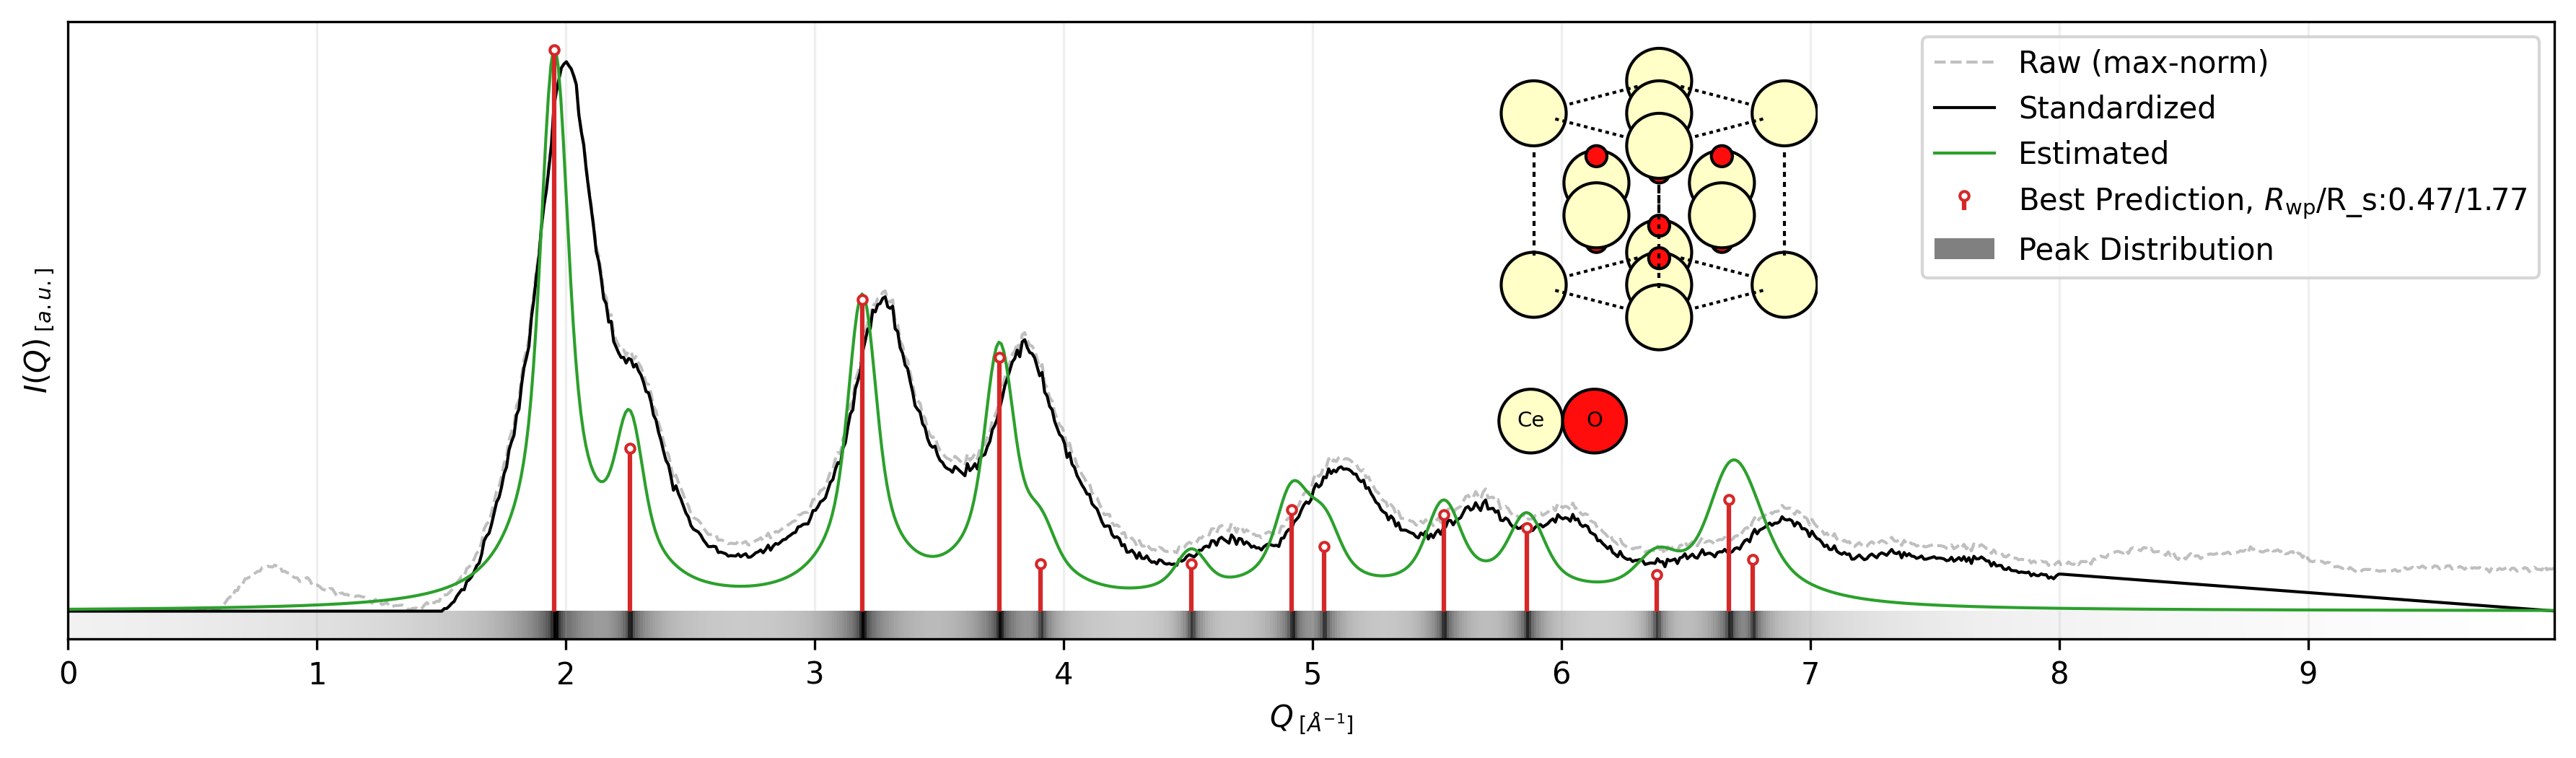

In [53]:
pipeline.plot_pxrd_and_structure(
    size_estimate=15,
    complexity_weight=0.1,
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.1,
    struc_offset_y=0.25,
    struc_scale_height=0.75,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,3*1.2),
    dpi=300,    
)